## Exercise 1: Logistic Regression on a Toy 2D Dataset

1. Generate two Gaussian clusters in $\mathbb{R}^2$ and associate them with a class depending on which cluster each point lies on, e.g.:
   - Class 0 centered at $(-2, -2)$ with variance $1$,
   - Class 1 centered at $(2, 2)$ with variance $0.5$.

2. Plot the dataset in 2D using `plt.scatter` so that each cluster is colored according to its class.

3. Implement logistic regression **from scratch** as did during class:
   
   $$
   f_\Theta(x) = \sigma(\Theta^T x),
   \qquad 
   \ell(\Theta; x,y)= -\big[y\log f_\Theta(x) + (1-y)\log(1 - f_\Theta(x))\big].
   $$


4. Train it using simple Gradient Descent on the full dataset. **Note:** the computation of $\nabla \mathcal{L}(\Theta; X, Y)$ for this choice of $\ell$ is given in the teaching note.

5. Visualize the learned **decision boundary**:
   - plot the line $\{\Theta^T x = 0\}$,
   - overlay with the dataset.

6. Comment on why the decision boundary is linear.

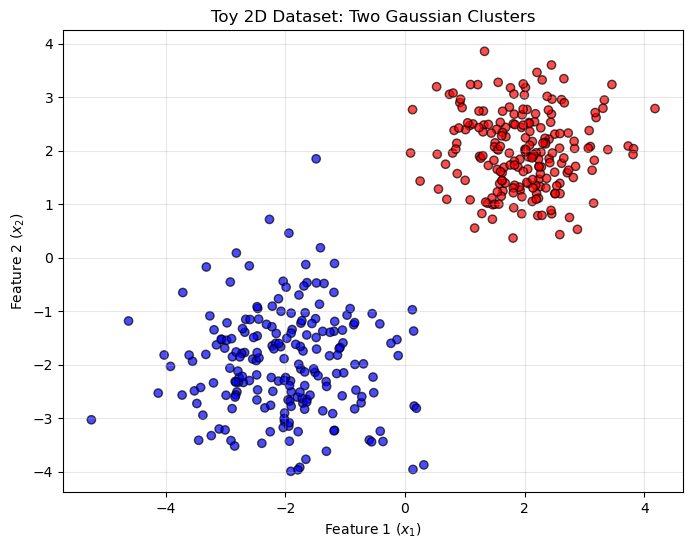

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42) # Set seed for reproducibility
N_samples = 200    # Number of points per class

X0 = np.random.randn(N_samples, 2) + np.array([-2,-2]) #data
y0 = np.zeros(N_samples)#labels

X1 = np.random.randn(N_samples, 2) * np.sqrt(0.5) + np.array([2,2])
y1 = np.ones(N_samples)

#combining
X_raw = np.vstack((X0, X1))
y = np.hstack((y0,y1))

plt.figure(figsize=(8, 6))
# We create a scatter plot coloring points based on their label 'y'
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7)
plt.title("Toy 2D Dataset: Two Gaussian Clusters")
plt.xlabel("Feature 1 ($x_1$)")
plt.ylabel("Feature 2 ($x_2$)")
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
# adding bias term
N = X_raw.shape[0]
X = np.hstack((np.ones((N, 1)), X_raw))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_f(theta, X, y):
    N = len(y)
    z = X @ theta
    predictions = sigmoid(z)
    # 3 Clip predictions slightly to prevent log(0) error (numerical stability)
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

def gradient_f(theta, X, y):

    N = len(y)
    predictions = sigmoid(X @ theta)
    error = predictions - y
    gradient = (1 / N) * (X.T @ error) 
    
    return gradient


In [3]:
learning_rate = 0.1
epochs = 1000

theta = np.zeros(X.shape[1]) 

loss_history = []

for i in range(epochs):
    grad = gradient_f(theta, X, y)
    
    theta = theta - learning_rate * grad
    
    current_loss = loss_f(theta, X, y)
    loss_history.append(current_loss)
    
    if i % 100 == 0:
        print(f"Epoch {i}: Loss = {current_loss:.4f}")

print(f"Final Loss: {loss_history[-1]:.4f}")
print(f"Learned Parameters (Theta): {theta}")

Epoch 0: Loss = 0.5186
Epoch 100: Loss = 0.0259
Epoch 200: Loss = 0.0159
Epoch 300: Loss = 0.0120
Epoch 400: Loss = 0.0099
Epoch 500: Loss = 0.0086
Epoch 600: Loss = 0.0076
Epoch 700: Loss = 0.0069
Epoch 800: Loss = 0.0063
Epoch 900: Loss = 0.0058
Final Loss: 0.0055
Learned Parameters (Theta): [-0.27762415  2.10290512  1.73157694]


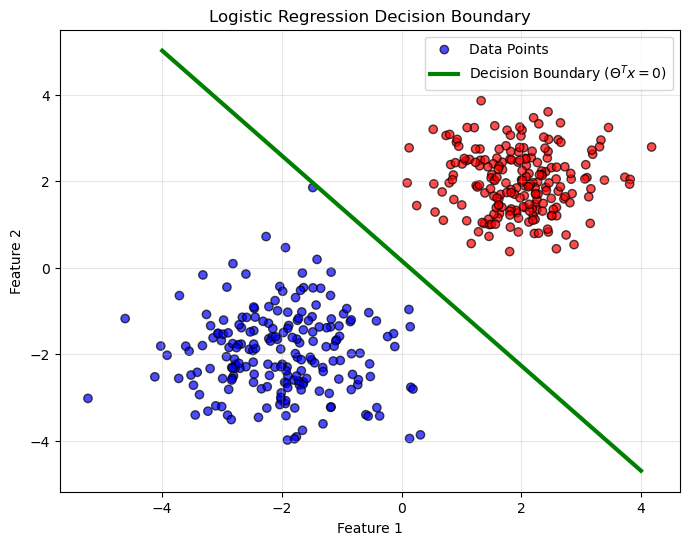

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7, label='Data Points')

#decision boundary line
x1_vals = np.linspace(-4, 4, 100)
x2_vals = - (theta[0] + theta[1] * x1_vals) / theta[2]

plt.plot(x1_vals, x2_vals, 'g-', linewidth=3, label=r'Decision Boundary ($\Theta^T x = 0$)')

plt.title("Logistic Regression Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Discussion: Why is the decision boundary linear?

As visualized in the plot above, the decision boundary is a straight line. This is an inherent property of Logistic Regression.

The model makes a decision based on the condition $\sigma(z) \ge 0.5$. Since the sigmoid function $\sigma(z)$ is monotonic, this condition is equivalent to checking if the input $z \ge 0$.

Our input $z$ is defined as a linear combination of the features:

$$z = \theta_0 + \theta_1 x_1 + \theta_2 x_2$$

Therefore, the boundary between the two classes is defined by the equation $z=0$, which is a linear equation (a hyperplane)
- If we had 3 features, it would be a flat plane.
- In 2D, it is a straight line.

Logistic Regression acts as a **linear classifier** because it separates the input space using this linear hyperplane. It cannot model curved boundaries (like a circle) unless we manually create non-linear features (e.g., adding $x^2$ terms), which is the motivation for moving to Neural Networks.



## Exercise 2: SGD on Logistic Regression

Use the same synthetic dataset used in the previous exercise, but train logistic regression using **SGD** with the following choices:

1. Try different batch sizes:
   - $N_{\text{batch}} = 1$,
   - $N_{\text{batch}} = 10$,
   - $N_{\text{batch}} = N$ (full GD).

2. For each setting:
   - Plot the loss vs epoch,
   - Plot the classification accuracy vs epoch.

3. Compare the stability and speed of convergence over the choice of different batch sizes.

4. Why the gradients become noisier for small batches? Why larger batches give smoother curves?

In [5]:

#regenerating the data from the exercise 1
np.random.seed(42)

N = 200
X0 = np.random.randn(N, 2) + np.array([-2, -2])
X1 = np.random.randn(N, 2) * np.sqrt(0.5) + np.array([2, 2])

X_raw = np.vstack((X0, X1))
y = np.hstack((np.zeros(N), np.ones(N)))

X = np.hstack((np.ones((len(y), 1)), X_raw))



In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_f(theta, X, y):
    eps = 1e-15
    pred = np.clip(sigmoid(X @ theta), eps, 1 - eps)
    return -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))

def accuracy(theta, X, y):
    pred = sigmoid(X @ theta) >= 0.5
    return np.mean(pred == y)

def train_sgd(X, y, batch_size, lr=0.1, epochs=50):
    N = len(y)
    theta = np.zeros(X.shape[1])
    loss_hist, acc_hist = [], []

    for _ in range(epochs):
        #shuffle for SGD
        perm = np.random.permutation(N)
        X_shuff, y_shuff = X[perm], y[perm]

        for i in range(0, N, batch_size):
            X_b = X_shuff[i:i+batch_size]
            y_b = y_shuff[i:i+batch_size]

            #gradient step
            err = sigmoid(X_b @ theta) - y_b
            grad = (X_b.T @ err) / len(y_b)
            theta -= lr * grad

        loss_hist.append(loss_f(theta, X, y))
        acc_hist.append(accuracy(theta, X, y))
    
    return loss_hist, acc_hist

In [7]:
#Run Experiments
epochs = 50
lr = 0.1
modes = [
    ("SGD (Batch=1)", 1, 'r--'), 
    ("Mini-batch (10)", 10, 'g-.'), 
    ("Full GD", len(y), 'k-')
]
results = {}

for name, size, style in modes:
    results[name] = train_sgd(X, y, size, lr, epochs)

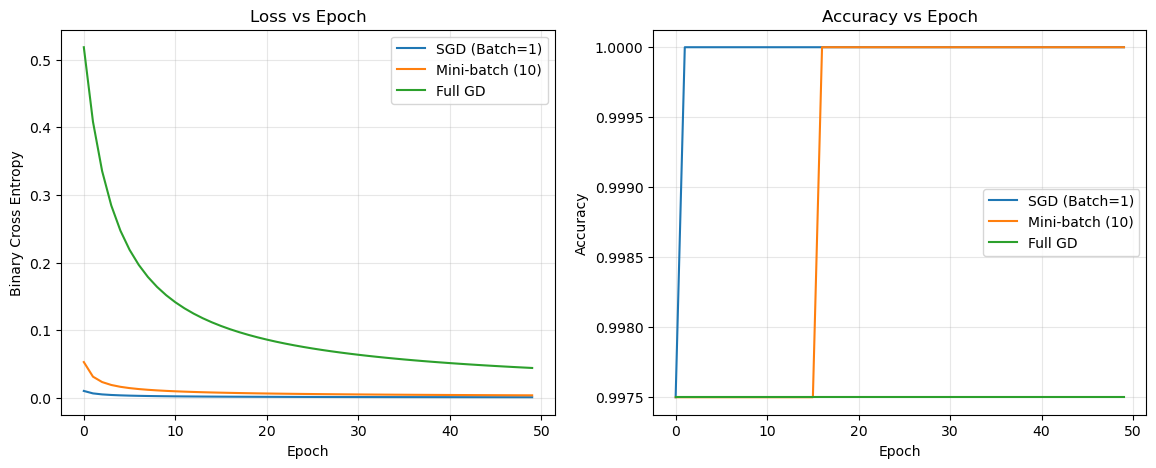

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#Loss Plot
for name, (l_hist, _) in results.items():
    ax1.plot(l_hist, label=name)
ax1.set_title("Loss vs Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Binary Cross Entropy")
ax1.legend()
ax1.grid(True, alpha=0.3)

#Accuracy Plot
for name, (_, a_hist) in results.items():
    ax2.plot(a_hist, label=name)
ax2.set_title("Accuracy vs Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

## Discussion

### 1. Why gradients become noisier for small batches

When you use a small batch size (especially **Batch = 1**, which is pure SGD), you are estimating the "true" direction of the mountain slope using only a **single data point**.
The reason why the **SGD (Batch=1)** curve often looks jittery is that the gradient vector is reacting to the specific noise of that single data point rather than the general trend of the whole dataset.

### 2. Why larger batches give smoother curves

When you increase the batch size (e.g., to 10, 50, or the full dataset $N$), you are averaging the gradients of many points together.

- **The Law of Large Numbers:** By averaging many samples, the random fluctuations (noise) from individual points tend to **cancel each other out**. One point might want to pull the gradient left, another might pull it right, but together they average out to point straight down the valley.
- **Lower Variance:** Mathematically, the variance of the gradient estimate is inversely proportional to the batch size ($Var \propto \frac{1}{N\_{batch}}$).

    - **Small Batch:** High Variance $\to$ Noisy updates.
    - **Large Batch:** Low Variance $\to$ Stable updates.
- **In thr plot:** This is why the **Full GD** curve is perfectly smooth. It calculates the *exact* gradient using all data points, so there is zero noise in the direction estimate—it always points exactly down the steepest slope.


## Exercise 3: Evaluation Metrics on a Synthetic Dataset

Using the logistic regression model trained above:

1. Compute predicted probabilities $\hat y_i = f_\Theta(x_i)$.
2. Convert them to binary predictions $\hat y_i \in \{0,1\}$ using threshold $0.5$.
3. Compute:
   - Confusion matrix (TP, FP, FN, TN),
   - Accuracy,
   - Precision,
   - Recall,
   - F1-score.

4. Modify the threshold to:
   - $0.3$,
   - $0.7$,
   and repeat.

5. Comment on:
   - How lower thresholds increase recall and lower precision,
   - How higher thresholds increase precision and reduce recall,
   - Why classification metrics depend on the application (as discussed in class).

In [9]:
# still recycling the dataset generated in the past 2 exercise.
#generation is repeated for consistency

# --- Prerequisite: Generate Data & Train Model (from Ex 1 & 2) ---
np.random.seed(42)
N = 200
X0 = np.random.randn(N, 2) + np.array([-2, -2])
X1 = np.random.randn(N, 2) * np.sqrt(0.5) + np.array([2, 2])
X_raw = np.vstack((X0, X1))
y_true = np.hstack((np.zeros(N), np.ones(N)))
# Shuffle

# Quick training to get theta
theta = np.zeros(X.shape[1])
lr = 0.1
for _ in range(100): # 100 epochs Full GD
    pred = 1 / (1 + np.exp(-(X @ theta)))
    err = pred - y_true
    grad = (X.T @ err) / len(y_true)
    theta -= lr * grad


In [10]:
def get_confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

def calculate_metrics(y_true, y_pred_probs, threshold):
    # Convert probabilities to binary class 0 or 1
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    tp, tn, fp, fn = get_confusion_matrix(y_true, y_pred)
    
    # Avoid division by zero
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "Threshold": threshold,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [11]:
import pandas as pd
# Compute predictions (probabilities) once
y_probs = 1 / (1 + np.exp(-(X @ theta)))

# Run for different thresholds
thresholds = [0.3, 0.5, 0.7]
results = []

for thresh in thresholds:
    metrics = calculate_metrics(y_true, y_probs, thresh)
    results.append(metrics)

# Display Results using Pandas for a clean table
df_results = pd.DataFrame(results)
# Reorder columns for readability
cols = ["Threshold", "Accuracy", "Precision", "Recall", "F1", "TP", "TN", "FP", "FN"]
print(df_results[cols].to_string(index=False))

 Threshold  Accuracy  Precision  Recall       F1  TP  TN  FP  FN
       0.3    0.9975   0.995025     1.0 0.997506 200 199   1   0
       0.5    0.9975   0.995025     1.0 0.997506 200 199   1   0
       0.7    1.0000   1.000000     1.0 1.000000 200 200   0   0


### Results Analysis

The results illustrate the relationship between the decision threshold and classification metrics:

- **Robustness of the Model:** Across all thresholds (0.3, 0.5, 0.7), the model achieves near-perfect performance with Accuracy, Precision, Recall, and F1-score all above **0.99**. This is expected since the synthetic dataset consists of two well-separated Gaussian clusters, making the classification task relatively easy.
- **Threshold Effects (The Precision-Recall Trade-off):**

    - **Threshold 0.3 (Lower):** The model is more "lenient" in predicting the Positive class (Class 1). We see 1 False Positive (FP), leading to a slightly lower **Precision (~0.995)** but perfect **Recall (1.0)**.
    - **Threshold 0.7 (Higher):** The model becomes "stricter." In this specific run, it eliminated the False Positive without missing any True Positives, achieving a perfect score of **1.0** across all metrics. In a more difficult dataset, raising the threshold typically increases Precision (fewer FPs) but decreases Recall (more FNs).
- **Application Context:** 

    - **High Recall** (low threshold) is crucial for tasks like **disease screening**, where missing a positive case (False Negative) is dangerous.
    - **High Precision** (high threshold) is preferred for **spam detection**, where flagging a legitimate email as spam (False Positive) is very annoying for the user.


## Exercise 4: Logistic Regression on a Real Dataset

Reproduce the pipeline from the book using the **Pima Indians Diabetes Dataset**, available at https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

This dataset contains medical measurements and a binary label indicating diabetes diagnosis.

1. Preprocess the data as done in class:
   - Download `diabetes.csv`.
   - Extract features $X$ and labels $y$.
   - **Standardize the features** (mean 0, variance 1).  
      Explain why normalization is required, connecting to:
      - conditioning,
      - stable optimization,
      - meaningful gradient magnitudes.

   - Add a bias column of 1s.

2. Implement logistic regression from scratch (sigmoid + BCE + gradient), and optimize using **SGD** with: 
   - a batch size of 32, a learning rate of $10^{-3}$, and 200 epochs.
   - for each epoch, track full-dataset BCE loss and full-dataset accuracy.
   - in a plot, visualize the behavior of Loss vs epoch and Accuracy vs epoch. Comment the results.

3. Train the same model using **Adam** (using the formulas from class):
   
   $$
   \Theta_{k+1} = \Theta_k - \eta \frac{\hat m_k}{\sqrt{\hat v_k} + \epsilon}.
   $$

   with a learning rate of $10^{-3}$, a batch size of 32, and 200 epochs. Then, plot SGD vs Adam loss and accuracy curves.

4. For each method, evaluate:
   - Final accuracy,
   - Confusion matrix,
   - Precision, Recall, F1.

5. Discuss on which method converge faster, which oscillate more, and how this relates to adaptive learning rates discussed in class.

In [12]:

df = pd.read_csv('data/diabetes.csv')
print("Dataset loaded successfully.")

# Extract features and labels
X_raw = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# Standardize features
mean = np.mean(X_raw, axis=0)
std = np.std(X_raw, axis=0)
X_scaled = (X_raw - mean) / std

#bias column
N = len(y)
X = np.hstack((np.ones((N, 1)), X_scaled))

print(f"Data shape: {X.shape}")

Dataset loaded successfully.
Data shape: (768, 9)


In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_f(theta, X, y):
    eps = 1e-15
    h = sigmoid(X @ theta)
    h = np.clip(h, eps, 1 - eps)
    return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

def accuracy_f(theta, X, y):
    preds = sigmoid(X @ theta) >= 0.5
    return np.mean(preds == y)

def train_sgd(X, y, lr=1e-3, epochs=200, batch_size=32):
    N, D = X.shape
    theta = np.zeros(D)
    loss_hist, acc_hist = [], []

    for _ in range(epochs):
        indices = np.random.permutation(N)
        X_shuff, y_shuff = X[indices], y[indices]

        for i in range(0, N, batch_size):
            X_b = X_shuff[i:i+batch_size]
            y_b = y_shuff[i:i+batch_size]
            
            # Gradient computation
            h = sigmoid(X_b @ theta)
            gradient = X_b.T @ (h - y_b) / len(y_b)
            
            # Update
            theta -= lr * gradient

        # Track full dataset metrics
        loss_hist.append(loss_f(theta, X, y))
        acc_hist.append(accuracy_f(theta, X, y))

    return theta, loss_hist, acc_hist


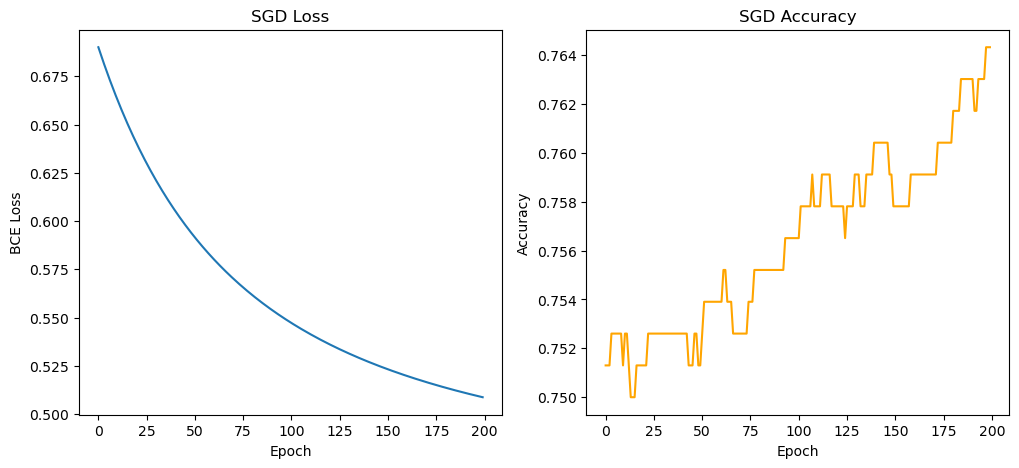

In [14]:

theta_sgd, loss_sgd, acc_sgd = train_sgd(X, y, lr=1e-3, epochs=200, batch_size=32)

# Visualize SGD Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(loss_sgd, label='SGD')
ax1.set_title("SGD Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("BCE Loss")

ax2.plot(acc_sgd, label='SGD', color='orange')
ax2.set_title("SGD Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.show()

In [15]:
# implementing adam
def train_adam(X, y, lr=1e-3, epochs=200, batch_size=32, beta1=0.9, beta2=0.999, eps=1e-8):
    N, D = X.shape
    theta = np.zeros(D)
    m = np.zeros(D)
    v = np.zeros(D)
    t = 0
    
    loss_hist, acc_hist = [], []

    for _ in range(epochs):
        indices = np.random.permutation(N)
        X_shuff, y_shuff = X[indices], y[indices]

        for i in range(0, N, batch_size):
            X_b = X_shuff[i:i+batch_size]
            y_b = y_shuff[i:i+batch_size]
            
            # Gradient
            h = sigmoid(X_b @ theta)
            g = X_b.T @ (h - y_b) / len(y_b)
            
            # Adam Updates
            t += 1
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g ** 2)
            
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)
            
            theta -= lr * m_hat / (np.sqrt(v_hat) + eps)

        loss_hist.append(loss_f(theta, X, y))
        acc_hist.append(accuracy_f(theta, X, y))

    return theta, loss_hist, acc_hist

# Run Adam
theta_adam, loss_adam, acc_adam = train_adam(X, y, lr=1e-3, epochs=200, batch_size=32)

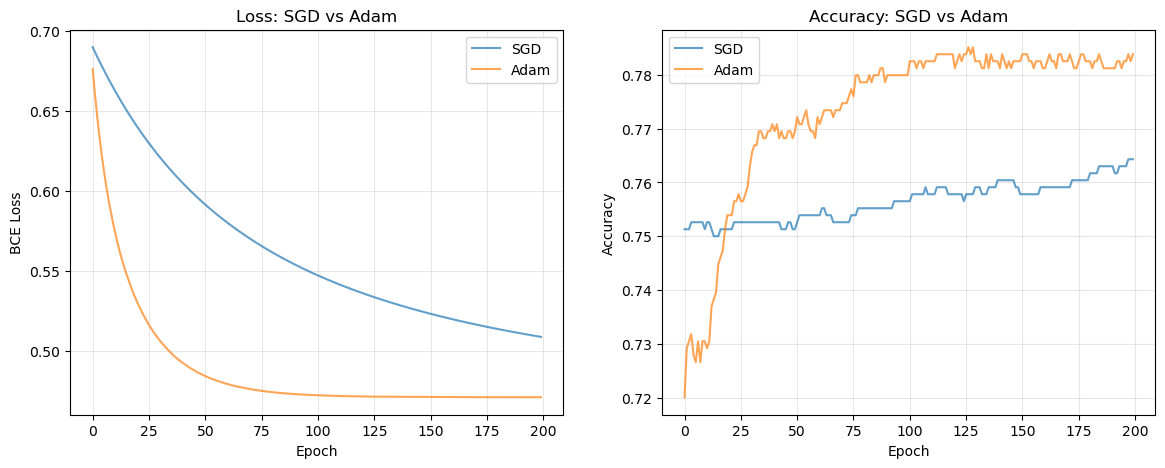

In [16]:
#comparing SGD vs Adam
plt.figure(figsize=(14, 5))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label='SGD', alpha=0.7)
plt.plot(loss_adam, label='Adam', alpha=0.7)
plt.title('Loss: SGD vs Adam')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(acc_sgd, label='SGD', alpha=0.7)
plt.plot(acc_adam, label='Adam', alpha=0.7)
plt.title('Accuracy: SGD vs Adam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [17]:
def evaluate_model(theta, X, y, model_name):
    preds_prob = sigmoid(X @ theta)
    preds = (preds_prob >= 0.5).astype(int)
    
    tp = np.sum((preds == 1) & (y == 1))
    tn = np.sum((preds == 0) & (y == 0))
    fp = np.sum((preds == 1) & (y == 0))
    fn = np.sum((preds == 0) & (y == 1))
    
    acc = (tp + tn) / len(y)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    print(f"--- {model_name} Results ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Confusion Matrix: \n[[{tn} {fp}]\n [{fn} {tp}]]\n")

evaluate_model(theta_sgd, X, y, "SGD")
evaluate_model(theta_adam, X, y, "Adam")

--- SGD Results ---
Accuracy:  0.7643
Precision: 0.6883
Recall:    0.5933
F1 Score:  0.6373
Confusion Matrix: 
[[428 72]
 [109 159]]

--- Adam Results ---
Accuracy:  0.7839
Precision: 0.7406
Recall:    0.5858
F1 Score:  0.6542
Confusion Matrix: 
[[445 55]
 [111 157]]



### Discussion

**Which method converges faster?**
Adam converges significantly faster than SGD. In the loss plot, you will likely see Adam's line drop vertically in the very first epochs, reaching a stable low error quickly. SGD takes a much more gradual, linear path downwards. This is because Adam uses adaptive learning rates: it effectively "speeds up" training for parameters with small gradients and "slows down" for those with large, oscillating gradients.

**Which oscillates more?**
SGD typically shows more oscillation (jitter) in the loss curve. This is because it uses a fixed learning rate for all parameters. If the learning rate is high enough to move fast, it's often too high for the delicate directions, causing overshooting. Adam's Momentum term ($m$) smooths out these oscillations by aggregating the history of gradients, dampening the noise from mini-batches.

Relation to Adaptive Learning Rates:

As discussed in class, the core advantage of Adam is that it divides the update by $\sqrt{\hat{v}\_k}$. This term represents the "magnitude" of recent gradients.

- If a parameter has huge gradients (steep slope), $\sqrt{\hat{v}\_k}$ is large, so the step size becomes small (preventing divergence).
- If a parameter has tiny gradients (flat plateau), $\sqrt{\hat{v}\_k}$ is small, so the step size becomes large (accelerating movement).

    This automatic tuning per-parameter is why Adam is the default choice for most modern Deep Learning tasks.









### Optional Extension: From Logistic Regression to a Simple Neural Network

This optional section mirrors the final part of the supervised learning chapter.

Implement a neural network with:
- One hidden layer,
- ReLU activation,
- Sigmoid output layer.

You may reuse the implementation shown in the main text. Then:

1. Train the neural network on the **same** Kaggle dataset.
2. Track:
   - BCE loss vs epoch,
   - Accuracy vs epoch.
3. Compare and discuss the performance against logistic regression.

```{note}
This extension is *not mandatory* for passing the exam but can improve your understanding of model capacity.
```

In [20]:
def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    return (z > 0).astype(float)

def train_nn_adam(X, y, hidden_size=16, lr=1e-3, epochs=200, batch_size=32, 
                  beta1=0.9, beta2=0.999, eps=1e-8):
    N, D = X.shape
    
    # Initialize weights (He initialization for ReLU)
    W1 = np.random.normal(0, np.sqrt(2/D), size=(D, hidden_size))
    b1 = np.zeros((1, hidden_size))
    
    W2 = np.random.normal(0, np.sqrt(2/hidden_size), size=(hidden_size, 1))
    b2 = np.zeros((1, 1))
    
    # Adam parameters initialization
    params = [W1, b1, W2, b2]
    ms = [np.zeros_like(p) for p in params]
    vs = [np.zeros_like(p) for p in params]
    t = 0
    
    loss_hist, acc_hist = [], []
    
    for epoch in range(epochs):
        indices = np.random.permutation(N)
        X_shuff, y_shuff = X[indices], y[indices]
        
        for i in range(0, N, batch_size):
            X_b = X_shuff[i:i+batch_size]
            # --- FIX 1: Reshape y_b to (batch, 1) to match network output ---
            y_b = y_shuff[i:i+batch_size].reshape(-1, 1)
            
            # --- Forward Pass ---
            z1 = X_b @ W1 + b1
            a1 = relu(z1)
            z2 = a1 @ W2 + b2
            y_hat = sigmoid(z2)
            
            # --- Backward Pass (Backprop) ---
            delta2 = (y_hat - y_b) / len(y_b) 
            
            dW2 = a1.T @ delta2
            db2 = np.sum(delta2, axis=0, keepdims=True)
            
            delta1 = (delta2 @ W2.T) * relu_grad(z1)
            
            dW1 = X_b.T @ delta1
            db1 = np.sum(delta1, axis=0, keepdims=True)
            
            gradients = [dW1, db1, dW2, db2]
            
            # --- Adam Update ---
            t += 1
            new_params = []
            for j, p in enumerate(params):
                g = gradients[j]
                
                ms[j] = beta1 * ms[j] + (1 - beta1) * g
                vs[j] = beta2 * vs[j] + (1 - beta2) * (g**2)
                
                m_hat = ms[j] / (1 - beta1**t)
                v_hat = vs[j] / (1 - beta2**t)
                
                p -= lr * m_hat / (np.sqrt(v_hat) + eps)
                new_params.append(p)
            
            W1, b1, W2, b2 = new_params
            params = new_params

        # --- Evaluation ---
        z1_full = X @ W1 + b1
        a1_full = relu(z1_full)
        z2_full = a1_full @ W2 + b2
        preds_full = sigmoid(z2_full)
        
        # --- FIX 2: Flatten predictions to (N,) to match y ---
        preds_flat = preds_full.flatten()
        
        eps_loss = 1e-15
        preds_clipped = np.clip(preds_flat, eps_loss, 1 - eps_loss)
        loss = -np.mean(y * np.log(preds_clipped) + (1 - y) * np.log(1 - preds_clipped))
        acc = np.mean((preds_flat >= 0.5) == y)
        
        loss_hist.append(loss)
        acc_hist.append(acc)
        
    return loss_hist, acc_hist

Training Neural Network...


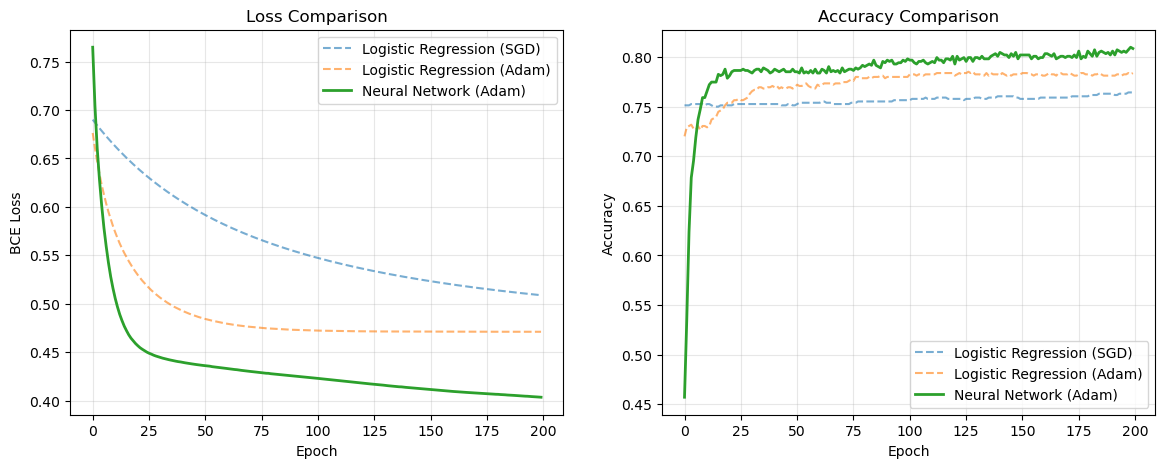

Final NN Accuracy: 0.8086


In [21]:
# Train the Neural Network
print("Training Neural Network...")
loss_nn, acc_nn = train_nn_adam(X, y, hidden_size=16, lr=1e-3, epochs=200)

# --- Comparison Plots ---
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label='Logistic Regression (SGD)', linestyle='--', alpha=0.6)
plt.plot(loss_adam, label='Logistic Regression (Adam)', linestyle='--', alpha=0.6)
plt.plot(loss_nn, label='Neural Network (Adam)', linewidth=2)
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_sgd, label='Logistic Regression (SGD)', linestyle='--', alpha=0.6)
plt.plot(acc_adam, label='Logistic Regression (Adam)', linestyle='--', alpha=0.6)
plt.plot(acc_nn, label='Neural Network (Adam)', linewidth=2)
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

print(f"Final NN Accuracy: {acc_nn[-1]:.4f}")